In [1]:
## Imports

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
import random as r
from math import *
from numpy import linalg as LA
import os
import osmnx as ox
from collections import deque
import pandas as pd


colormap = "PuRd"

## Exemples


Petersen = nx.petersen_graph()
C6 = nx.cycle_graph(6)
Biparti34 = nx.complete_bipartite_graph(3,4)





def downloadVille(location,nom_fichier):
    base_filepath = "data/"
    G = ox.graph_from_place(location, network_type="drive")
    G = rename_nodes(G)

    filepath = base_filepath + nom_fichier + ".graphml"
    ox.save_graphml(G, filepath)


def loadVille(nom_fichier):
    base_filepath = "data/"
    filepath = base_filepath + nom_fichier + ".graphml"

    return ox.load_graphml(filepath)


def rename_nodes(G):
    return nx.convert_node_labels_to_integers(G)



Piedmont = loadVille("piedmont")
# Paris = loadVille("paris")


Grid8x8 = rename_nodes(nx.grid_2d_graph(8,8))
pos8x8 = {}
for i in range(64):
    pos8x8[i] = [i//8, i%8]

hub8x8 = [0, 12, 37, 15, 32, 50, 63]

hubPiedmont = [52, 300, 70, 14, 129, 276, 179, 8, 218, 184, 318, 150, 228, 246]


## Simulation uniforme


def simulation(G, nHub, max_chemins):
    prepG = Init_Preprocessing(G)
    mat = random_matrix(G, nHub, max_chemins)
    print_compare_congestion(G, prepG, mat)



def random_matrix(G, nHub, max_chemins):
    hubs = random_hub(G,nHub)
    return generate_requetes(hubs, max_chemins)


def random_hub(G, N):
    n = len(G)
    return r.sample(list(G.nodes()), N)


def remplit_congestion(G, dict_congestion):
    """ Reçoit le dictionnaire des arêtes utilisées et renvoie une copie de G avec un attribut congestion sur les arêtes du graphe """
    H = G.copy()
    if H.is_multigraph():
        for (u,v) in H.edges():
            for k in range(len(H[u][v])):
                H[u][v][k]["congestion"] = 0
        for (u,v) in dict_congestion.keys():
            H[u][v][0]["congestion"] = dict_congestion[(u,v)]
    else:
        for (u,v) in H.edges():
            H[u][v]["congestion"] = 0
        for (v,u) in H.edges():
            H[u][v]["congestion"] = 0
        for (u,v) in dict_congestion.keys():
            H[u][v]["congestion"] = dict_congestion[(u,v)]
    return H



def congestion_tout_ou_rien(G, prepG, dict_requetes):
    """ Renvoie une copie de G avec un attribut congestion sur les arrêtes. """
    dict_congestion = {}
    nb_pcc = sum([dict_requetes[k] for k in dict_requetes.keys()])
    for k in dict_requetes.keys():
        #print("k2", k)
        (dep,arr) = k
        try :
            #print("alo")
            path = Uniforme_PCC_depart_arrivee_dynamique(G, prepG, dep, arr)
            for j in range(len(path)-1):
                u,v = path[j], path[j+1]
                dict_congestion[(u,v)] = dict_congestion.setdefault((u,v), 0) + dict_requetes[k]
        except Exception:
            #print("alo2")
            pass
    #print(dict_congestion, sum(dict_congestion.values()))
    return remplit_congestion(G, dict_congestion)



def congestion_uniforme(G, prepG, dict_requetes):
    """ Renvoie une copie de G avec un attribut congestion sur les arrêtes. """
    dict_congestion = {}
    nb_pcc = sum([dict_requetes[k] for k in dict_requetes.keys()])
    for k in dict_requetes.keys():
        #print("k", k)
        (dep,arr) = k
        for i in range(dict_requetes[k]):
            try:
                path = Uniforme_PCC_depart_arrivee_dynamique(G, prepG, dep, arr)
                #print("path",path)
                for j in range(len(path)-1):
                    u,v = path[j], path[j+1]
                    dict_congestion[(u,v)] = dict_congestion.setdefault((u,v), 0) + 1
            except Exception:
                pass
    #print(dict_congestion, sum(dict_congestion.values()))
    return remplit_congestion(G, dict_congestion)



def generate_requetes(bound_nodes, max_chemins):
    """ Génère un dictionnaire de requêtes. On demande un nombre aléatoire de pcc entre chaque paire de noeuds remarquables """
    dict_requetes = {}
    for dep in bound_nodes:
        for arr in bound_nodes:
            if dep != arr:
                dict_requetes[(dep,arr)] = r.randint(0, max_chemins)
    return dict_requetes



def print_congestion(G):
    """ Affiche un graphe en colorant les arrêtes en fonction de sa congestion """
    ec = ox.plot.get_edge_colors_by_attr(G, attr="congestion", cmap=colormap)
    fig, ax = ox.plot_graph(G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3, show= False)
    cb = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap), ax=ax, orientation='vertical')
    cb.set_label('Congestion', fontsize = 20)
    fig.show()



def print_compare_congestion(G, prepG, dict_requetes):
    G1 = congestion_tout_ou_rien(G, prepG, dict_requetes)
    G2 = congestion_uniforme(G, prepG, dict_requetes)


    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Tout ou rien")
    ax2.set_title("Uniforme")

    print(max([G2[u][v][0]["congestion"] for (u,v) in G2.edges()]))
    print(max([G1[u][v][0]["congestion"] for (u,v) in G1.edges()]))

    liste_valeurs = [G1[u][v][0]["congestion"] for (u,v) in G1.edges()] + [G2[u][v][0]["congestion"] for (u,v) in G2.edges()]
    vmin=min(liste_valeurs)
    vmax=max(liste_valeurs)
#     norm=plt.Normalize(vmin=vmin, vmax=vmax)
#     cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), orientation='vertical')
#     cb.set_label('Congestion')


    ec1 = ox.plot.get_edge_colors_by_attr(G1, attr="congestion", cmap=colormap)
    print("ec1")
    print(ec1)
    ox.plot_graph(G1, ax = ax1, node_color="w", node_edgecolor="k", node_size=0, edge_color=ec1, edge_linewidth=3, show= False)
    
    ec2 = ox.plot.get_edge_colors_by_attr(G2, attr="congestion", cmap=colormap)
    ox.plot_graph(G2, ax = ax2, node_color="w", node_edgecolor="k", node_size=0, edge_color=ec2, edge_linewidth=3, show= False)

    fig.show()


## Fonctions

def Dijkstra_DAG(G,source):
    """Renvoie un tuple (predecesseur,distance) avec predecesseur le DAG associé au Dijkstra à partir de la source sous la forme d'un dictionnaire noeud: liste de predecesseurs et distance le dictionnaire des distances au point source"""
    pred,dist = nx.dijkstra_predecessor_and_distance(G,source)
    return pred,dist


def BFS_DAG(G,source):
    """Renvoie un tuple (predecesseur,distance) avec predecesseur le DAG associé au BFS à partir de la source sous la forme d'un dictionnaire noeud: liste de predecesseurs et distance le dictionnaire des distances au point source"""
    pred = {}
    dist = {}
    n,m = len(G.nodes()), len(G.edges())

    seen = [False for i in range(n)]
    fifo = deque([])

    seen[source] = True
    pred[source] = []
    fifo.append(source)

    while (len(fifo) > 0):
        current_node = fifo.popleft()
        dist[current_node] = 0 if current_node==source else dist[pred[current_node][0]] + 1

        for neighbor in G.neighbors(current_node):
            if not seen[neighbor]:
                seen[neighbor] = True
                fifo.append(neighbor)
                pred[neighbor] = [current_node]
            elif neighbor != source and dist[pred[neighbor][0]] == dist[current_node]:
                pred[neighbor].append(current_node)

    return pred,dist




def Table_PCC(n,pred,dist,source):
    """Prend en argument le couple (DAG des predecesseurs,dictionnaire des distance) dans Dijsktra qui part de source. Renvoie un tableau avec en position i le nombre de plus court chemins qui partent de la source et arrivent en i"""
    table = np.zeros(n)

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme
    return table


def Table_PCC_In_Place(pred,dist,source,table):
    """Même fonction que Table_PCC mais en remplissant la table passée en argument (supposée de la bonne taille)"""

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme


def Ajoute_somme_partielle_dag_IN_PLACE(pred,table):
    """ Après application de la fonction pred[k] = [ (pred de k, somme partielle sur les autres pred de k des pcc (source)--> (pred de k)), ... ] """
    for k in pred.keys():
        somme_partielle = 0
        for i in range(len(pred[k])):
            pred_de_k = pred[k][i]
            somme_partielle += table[pred_de_k]
            pred[k][i] = (pred_de_k, somme_partielle)


## Algo dynamique


def Init_Preprocessing(G):
    """ Renvoie un tuple (dags, dico_departs_arrivees, sources_vues) avec
        - dags = dico des DAG de predecesseurs
        dags[i] = DAG de predecesseurs lors d'un BFS partant de i avec la somme partielle en 2eme coordonnée
        dags[depart][i][1] = dags[depart][i-1][1] + nb de PCC (depart)-->(dags[depart][i])

        - dico_departs_arrivees = dico de tables de longueur n
        dico_departs_arrivees[depart][j] = table_departs_arrivees[depart][j-1] + nb de PCC (depart)-->(j)

        - sources_vues = liste de taille n qui indique si on a déjà traité la source ou non """

    dags = {}
    dico_departs_arrivees = {}
    sources_vues = [False for i in range(len(G.nodes()))]
    return (dags, dico_departs_arrivees, sources_vues)



def Update_Preprocessing_source(G, prepG, source, dijkstra = False):
    """ Fait le preprocessing pour une source "source". """

    n = len(G)
    dags, dico_departs_arrivees, sources_vues = prepG


    pred,dist = Dijkstra_DAG(G,source) if dijkstra else BFS_DAG(G, source)
    dags[source] = pred
    table_PCC = Table_PCC(n,pred,dist,source)
    Ajoute_somme_partielle_dag_IN_PLACE(pred,table_PCC)                         # On ajoute à chaque prédecesseurs, la somme partielle du nombre de pcc entre (source) et lui.


    # Table pour déterminer l'arrivée
    table_arrivees = np.copy(table_PCC)
    for k in range(n-1):
        table_arrivees[k+1] += table_arrivees[k]                        #table_departs_arrivees[depart][k+1] = table_departs_arrivees[depart][k] + nb de PCC (depart)-->(k+1)
    dico_departs_arrivees[source] = table_arrivees

    sources_vues[source] = True






def Unranking_PCC_depart_arrivee_dynamique(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    dags = preprocessing[0]

    dag_travail = dags[depart]

    if not (arrivee in dag_travail):
        raise Exception("depart et arrivee pas dans la même composante connexe")

    if len(dag_travail[arrivee]) > 0:
        nb_pcc_depart_arrivee = dag_travail[arrivee][-1][1]
        rang_reduit = rang % nb_pcc_depart_arrivee

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        liste_pred = dag_travail[noeud_courant]
        indice_nv_noeud = recherche_dicho_par_coordonnee(liste_pred,rang_reduit,1)
        if indice_nv_noeud > 0:
            rang_reduit = rang_reduit - liste_pred[indice_nv_noeud - 1][1]

        noeud_courant = liste_pred[indice_nv_noeud][0]

        chemin.append(noeud_courant)

    chemin.reverse()
    return chemin



def Uniforme_PCC_depart_arrivee_dynamique(G, prepG, depart, arrivee):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins entre depart et arrivee"""
    sources_vues = prepG[2]
    if not sources_vues[depart]:
        Update_Preprocessing_source(G, prepG, depart)

    dico_departs_arrivees = prepG[1]
    nb_chemins = dico_departs_arrivees[depart][arrivee] if arrivee == 0 else dico_departs_arrivees[depart][arrivee] - dico_departs_arrivees[depart][arrivee-1]
    rang = r.randint(0,nb_chemins-1)

    return Unranking_PCC_depart_arrivee_dynamique(prepG, depart, arrivee ,rang)





def Unranking_PCC_depart_dynamique(preprocessing, depart, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin partant de départ de rang 'rang' """

    dico_departs_arrivees = preprocessing[1]
    rang_reduit = rang % int(dico_departs_arrivees[depart][-1])

    # On trouve le noeud d'arrivée
    arrivee = recherche_dicho(dico_departs_arrivees[depart],rang_reduit)

    return Unranking_PCC_depart_arrivee_dynamique(preprocessing,depart,arrivee,rang_reduit)




def Uniforme_PCC_depart_dynamique(G, prepG, depart):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins partant de depart"""
    sources_vues = prepG[2]
    if not sources_vues[depart]:
        Update_Preprocessing_source(G, prepG, depart)

    dico_departs_arrivees = prepG[1]
    nb_chemins = dico_departs_arrivees[depart][-1]
    rang = r.randint(0,nb_chemins-1)

    return Unranking_PCC_depart_dynamique(prepG, depart, rang)



## Dessin

def Draw_path(G,prepG):
    n = len(G)
    dep = r.randint(0, n-1)
    path = Uniforme_PCC_depart_dynamique(G,prepG,dep)
    plt.clf()
    ox.plot_graph_route(G, path, orig_dest_size=0, node_size=0, show = False)[0].show()


def Draw_path_bounds(G,prepG, dep, arr):
    path = Uniforme_PCC_depart_arrivee_dynamique(G,prepG,dep,arr)
    print(path)
    plt.clf()
    ox.plot_graph_route(G, path, orig_dest_size=0, node_size=0, show = False)[0].show()




## Utils



def recherche_dicho(table,rang):
    """Renvoie l'indice i tel que table[i-1] <= rang < table[i]"""
    if (rang < table[0]):
        return 0

    a = 0
    b = len(table)-1

    while(b-a > 1):
        #On garde l'invariant table[a] <= rang < table[b]
        m = (a + b)//2
        if table[m]<=rang:
            a = m
        else:
            b = m
    return b


def recherche_dicho_par_coordonnee(table,rang,coordonnee):
    """Renvoie l'indice i tel que table[i-1][coordonnee] <= rang < table[i][coordonnee]"""
    if (rang < table[0][coordonnee]):
        return 0

    a = 0
    b = len(table)-1

    while(b-a > 1):
        #On garde l'invariant table[a][coordonnee] <= rang < table[b][coordonnee]
        m = (a + b)//2
        if table[m][coordonnee]<=rang:
            a = m
        else:
            b = m
    return b



def inverse_dist(dist):
    """Prend le dictionnaire des distance et renvoie un dictionnaire où inv[d] = [liste des à distance d]"""
    inverse = {}
    for noeud,distance in dist.items():
        inverse.setdefault(distance, []).append(noeud)
    return inverse



/home/mehdi/.sage/local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


3046
3063
ec1
0    78   0    (0.8518262206843522, 0.7685505574778931, 0.877...
     98   0    (0.9194156093810073, 0.8984236831987698, 0.945...
1    2    0    (0.9686274509803922, 0.9568627450980393, 0.976...
     6    0    (0.8798769703960015, 0.8276047673971549, 0.908...
     169  0    (0.9253210303729335, 0.905436370626682, 0.9494...
                                     ...                        
349  73   0    (0.9253210303729335, 0.905436370626682, 0.9494...
350  29   0    (0.9686274509803922, 0.9568627450980393, 0.976...
     309  0    (0.9686274509803922, 0.9568627450980393, 0.976...
     24   0    (0.9686274509803922, 0.9568627450980393, 0.976...
351  214  0    (0.9686274509803922, 0.9568627450980393, 0.976...
Length: 944, dtype: object


/tmp/ipykernel_4960/102819552.py:195: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


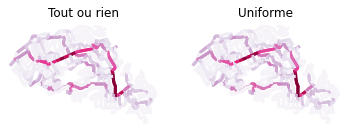

In [2]:
simulation(Piedmont, 30, 50)

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_graph_with_congestion_heatmap(graph):
    """
    Plots a NetworkX graph with edges colored according to their 'congestion' values as a heat map.

    Parameters:
    graph (networkx.Graph): The input NetworkX graph.
    """
    # Extract congestion values and determine the min and max
    congestion_values = [data['congestion'] for u, v, data in graph.edges(data=True) if 'congestion' in data]

    # Handle the case when there are no congestion attributes in the graph
    if not congestion_values:
        raise ValueError("No 'congestion' attribute found on any edge in the graph.")

    min_congestion = min(congestion_values)
    max_congestion = max(congestion_values)

    # Create a colormap
    norm = mcolors.Normalize(vmin=min_congestion, vmax=max_congestion)
    cmap = plt.cm.viridis
#     cmap = "PuRd"

    # Draw the graph
    pos = nx.spring_layout(graph)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos)

    # Draw edges with colors based on congestion values
    for u, v, data in graph.edges(data=True):
        if 'congestion' in data:
            edge_color = cmap(norm(data['congestion']))
            nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], edge_color=[edge_color], width=2)
        else:
            nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], edge_color='grey', width=2)

    # Draw labels
    nx.draw_networkx_labels(graph, pos)

    # Create colorbar as legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a new figure and axis for the colorbar
    fig, ax = plt.subplots()
    plt.colorbar(sm, ax=ax)
    ax.remove()  # Hide the axes but keep the colorbar

    # Show plot
    plt.title("Graph with Edge Congestion Heatmap")
    plt.axis('off')
    plt.show()


In [4]:
nHub = 10
max_chemins = 10000
g = rename_nodes(nx.grid_2d_graph(128,128))
g = nx.to_directed(g)
prepG = Init_Preprocessing(g)
mat = random_matrix(g, nHub, max_chemins)
g1 = congestion_tout_ou_rien(g,prepG,mat)
#prepG = Init_Preprocessing(g)
g2 = congestion_uniforme(g,prepG,mat)

In [5]:
#plot_graph_with_congestion_heatmap(g1)

In [6]:
#plot_graph_with_congestion_heatmap(g2)

In [7]:
def plot_congestion_histogram(graph, file_name, bins=10):
    """
    Generates a histogram of the 'congestion' values on the edges of a NetworkX graph.

    Parameters:
    graph (networkx.Graph): The input NetworkX graph.
    bins (int): Number of histogram bins. Default is 10.
    """
    # Extract congestion values
    congestion_values = [data['congestion'] for u, v, data in graph.edges(data=True) if 'congestion' in data and graph[u][v]['congestion']>0]

    # Handle the case when there are no congestion attributes in the graph
    if not congestion_values:
        raise ValueError("No 'congestion' attribute found on any edge in the graph.")

    # Plot histogram
    #plt.yscale('log')
    plt.hist(congestion_values, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Histogram of Edge Congestion Values")
    plt.xlabel("Congestion")
    plt.ylabel("Frequency (log scale)")
    plt.grid(True)
    plt.savefig(file_name)
    plt.show()


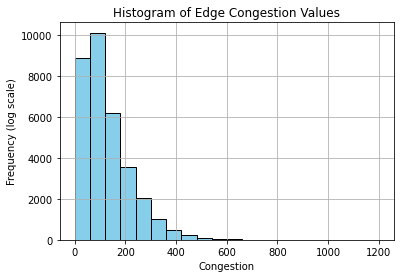

In [265]:
plot_congestion_histogram(g1,"128_traffic_all.pdf",bins = 20)

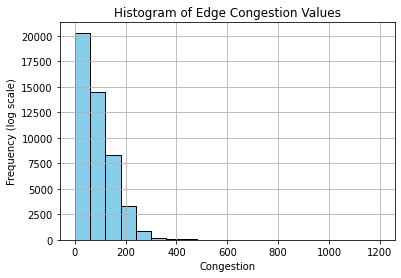

In [266]:
plot_congestion_histogram(g2,"128_traffic_unif.pdf", bins = 20)

In [293]:
max( g1[e[0]][e[1]]['congestion']  for e in g1.edges() )

1484

In [294]:
max( g2[e[0]][e[1]]['congestion']  for e in g2.edges() )

1262

In [9]:
def plot_congestion_histogram2(graph1, graph2, filename, bins=10):
    """
    Generates a histogram of the 'congestion' values on the edges of two NetworkX graphs,
    with the bars superimposed in different colors.

    Parameters:
    graph1 (networkx.Graph): The first input NetworkX graph.
    graph2 (networkx.Graph): The second input NetworkX graph.
    bins (int): Number of histogram bins. Default is 10.
    """
    # Extract congestion values for both graphs
    congestion_values1 = [data['congestion'] for u, v, data in graph1.edges(data=True) if 'congestion' in data]
    congestion_values2 = [data['congestion'] for u, v, data in graph2.edges(data=True) if 'congestion' in data]

    # Handle the case when there are no congestion attributes in the graphs
    if not congestion_values1:
        raise ValueError("No 'congestion' attribute found on any edge in the first graph.")
    if not congestion_values2:
        raise ValueError("No 'congestion' attribute found on any edge in the second graph.")

    # Plot histograms with superimposed bars
    plt.hist(congestion_values1, bins=bins, color='skyblue', edgecolor='black', alpha=0.5, label='all-or-nothing')
    plt.hist(congestion_values2, bins=bins, color='salmon', edgecolor='black', alpha=0.5, label='uniform')
    plt.yscale('log')
    plt.title("Histogram of Edge Congestion Values")
    plt.xlabel("Congestion")
    plt.ylabel("Frequency (log scale)")
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(filename)
    plt.show()

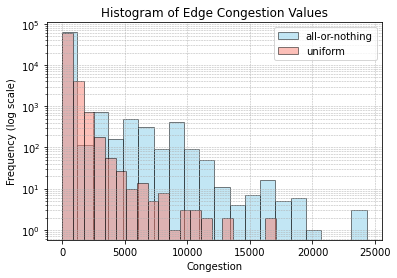

In [10]:
plot_congestion_histogram2(g1,g2,"128_traffic.pdf",bins = 20)

In [291]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_congestion_density(graph1, graph2, bins=10):
    """
    Generates a density plot of the 'congestion' values on the edges of two NetworkX graphs,
    with the curves superimposed in different colors.

    Parameters:
    graph1 (networkx.Graph): The first input NetworkX graph.
    graph2 (networkx.Graph): The second input NetworkX graph.
    bins (int): Number of histogram bins (used for KDE bandwidth estimation). Default is 10.
    """
    # Extract congestion values for both graphs
    congestion_values1 = [1+data['congestion'] for u, v, data in graph1.edges(data=True) if 'congestion' in data]
    congestion_values2 = [1+data['congestion'] for u, v, data in graph2.edges(data=True) if 'congestion' in data]

    # Handle the case when there are no congestion attributes in the graphs
    if not congestion_values1:
        raise ValueError("No 'congestion' attribute found on any edge in the first graph.")
    if not congestion_values2:
        raise ValueError("No 'congestion' attribute found on any edge in the second graph.")

    # Plot density curves
    sns.kdeplot(congestion_values1, color='skyblue', label='Graph 1', bw_adjust=1.5)
    sns.kdeplot(congestion_values2, color='salmon', label='Graph 2', bw_adjust=1.5)

    plt.yscale('log')
    plt.title("Density Plot of Edge Congestion Values")
    plt.xlabel("Congestion")
    plt.ylabel("Density (log scale)")
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

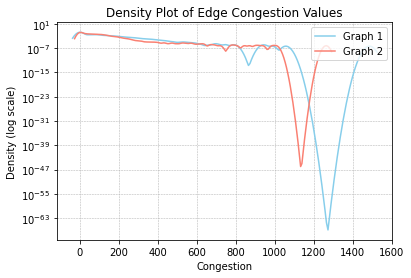

In [292]:
plot_congestion_density(g1,g2,bins = 20)